# Dopamine mediates the bidirectional update of interval timing

Anthony M.V. Jakob$^{1,2}$, John G. Mikhael$^{2,3}$, Allison E. Hamilos$^{2,3}$, John A. Assad$^{2,4}$, Samuel J. Gershman$^{5,6}$

$^1$Section of Life Sciences Engineering, École Polytechnique Fédérale de Lausanne, Switzerland  
$^2$Department of Neurobiology, Harvard Medical School, Boston, MA 02115  
$^3$MD-PhD Program, Harvard Medical School, Boston, MA 02115  
$^4$Istituto Italiano di Tecnologia, Genova, Italy  
$^5$Department of Psychology and Center for Brain Science, Harvard University, Cambridge, MA 02138  
$^6$Center for Brains, Minds and Machines, Massachusetts Institute of Technology, Cambridge, MA 02139  


In [1]:
using Printf, FileIO
using Pipe: @pipe

In [128]:
include("main.jl")
include("fig2.jl");

## Parameters

In [3]:
dir_raw       = "C:/Users/antho/Documents/harvard/time_perception/GCaMP6f_and_tdTomato_Photometry_and_Behavior/"
dir_processed = "C:/Users/antho/Documents/harvard/time_perception/processed/"

verbose = 0
const nbins = 20;

## Process raw photometry signals

In [4]:
binmode = AbsBin()
binalign = AlignLick()

dirs = readdir(dir_raw)
dirs = filter(d -> !(d in EXCLUDED_DIRS), dirs);

In [5]:
meta_all = nothing
bins_all = nothing

for dir in dirs
    meta, bins = get_bins(dir_raw * "/" * dir, nbins;
        binmode=binmode,
        binalign=binalign,
        cachedir=dir_processed,
        verbose=verbose)
    
    if bins_all === nothing
        meta_all = meta
        bins_all = bins
    else
        append!(meta_all, meta)
        append!(bins_all, bins)
    end
end

Sessions with more `lamp_off`s or `lamp_on`s than cues:
- b3_day7
- b5_day16_allop0_file1
- b5_day16_allop0_file2
- b6_day13_allop0
- b6_day14_hybop0_file2

All manually checked, we can simply remove the extra events at the end of the session.

## Figure 2AB: Compute empirical bidirectional plasticity function

In [211]:
# forward and reverse analysis
function get_coefs(lickbin;baseline_normalization=true, reverse=false)
    coefs  = zeros(nbins, length(mice))
    errors = zeros(nbins, length(mice))

    for (m, mouse) in enumerate(mice)
        coefs[:,m], errors[:,m], _, _ = get_bidirectional_fn(
            meta_all, bins_all, mouse_sessions[m];
            baseline_normalization=baseline_normalization,
            lickbin=lickbin,
            reverse=reverse)
    end
    
    coef_agg, error_agg, _, _ = get_bidirectional_fn(
        meta_all, bins_all, sessions;
        baseline_normalization=baseline_normalization,
        lickbin=lickbin,
        reverse=reverse)
    
    return hcat(coefs, coef_agg), hcat(errors, error_agg)
end;

In [132]:
sessions = unique(meta_all.session)

# sort mice by first letter, then by number
mice = unique(meta_all.mouse)
sort!(mice, by=m -> (m[1], parse(Int, m[2:end])))

# get sessions for each mouse
mouse_sessions = map(m -> filter(s -> startswith(uppercase(s), m), sessions), mice);

In [ ]:
lickbin = (3.3, 7)

fig2A_coefs, fig2A_errors = get_coefs(lickbin, reverse=false)
fig2B_coefs, fig2B_errors = get_coefs(lickbin, reverse=true)
fig2AB_labels = vcat(mice, "All");

In [ ]:
bintimes = get_bintimes(-mean(lickbin), 0, nbins, AbsBin(), AlignLick())
x = (bintimes[1:end-1] + bintimes[2:end]) / 2.0

fig2AB = plot_fig_2_A_B(
    x,
    fig2A_coefs, fig2A_errors,
    fig2B_coefs, fig2B_errors,
    fig2AB_labels
)

### Different lick intervals

In [338]:
intervals = 2.5:0.5:6.5 |> collect
interval_label(index) = "$(intervals[index]) - $(intervals[index]+0.5)s"

coefs  = zeros(nbins, length(intervals))
errors = zeros(nbins, length(intervals))

n = zeros(length(intervals))

for (i, b) in enumerate(intervals)
    coefs[:,i], errors[:,i], c, _ = get_bidirectional_fn(
        meta_all, bins_all, sessions;
        baseline_normalization=true,
        lickbin=b .+ (0, 0.5),
        reverse=false)
    
    n[i] = nrow(c)
end
;

#### Subplots

In [362]:
plots = Array{Plots.Plot}(undef, length(intervals)) # {Plots.GRBackend}
smooth_arr(arr) = smooth(arr, :rect, 3)

for i in 1:length(intervals)
    label = interval_label(i)
    
    p = plot(x, coefs[:,i] |> smooth_arr, ribbon=errors[:,i] |> smooth_arr,
        size=(800, 400),
        xlim=(-7, 3),
        ylim=(-0.15, 0.15),
        grid=:off,
        linewidth=3,
        fillalpha=0.3,
        opacity=1,
        color=i,
        legend=nothing,
        title="$label, n = $(round(Int, n[i]))"
    )

    params = Dict(:linestyle=>:dash, :color=>:grey, :label=>"")
    vline!([0, -intervals[i]-0.25]; params...)
    hline!([0]; params...)
    
    plots[i] = p
end

plot(plots..., size=(1200, 700), layout=@layout([° ° °; ° ° °; ° ° °]))

#### GIF

In [364]:
anim = @animate for i in 1:length(intervals)
    plot()
    
    for j in 1:i-1
        plot!([],[], color=j, label=interval_label(j))
    end
    
    label = interval_label(i)
    
    plot!(x, coefs[:,i] |> smooth_arr, ribbon=errors[:,i] |> smooth_arr,
        size=(800, 400),
        xlim=(-7, 3),
        ylim=(-0.15, 0.15),
        grid=:off,
        linewidth=3,
        fillalpha=0.3,
        opacity=1,
        color=i,
        label=label,
        legend=:outerright,
        legendtitle="Intervals",
        title="Interval = $label, n = $(round(Int, n[i]))"
    )

    params = Dict(:linestyle=>:dash, :color=>:grey, :label=>"")
    vline!([0, -intervals[i]-0.25]; params...)
    hline!([0]; params...)
    
    for j in i+1:length(intervals)
        plot!([],[], color=j, label=interval_label(j))
    end
end

gif(anim, "anim.gif", fps = 1);

LoadError: UndefVarError: interval_label not defined

### Contrast analysis

In [12]:
do_ttest(coef) = OneSampleTTest(coef[4,1:end-1], coef[9,1:end-1]);

In [13]:
do_ttest(fig2A_coefs)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          0.243326
    95% confidence interval: (0.1815, 0.3051)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-05

Details:
    number of observations:   12
    t-statistic:              8.664233178766928
    degrees of freedom:       11
    empirical standard error: 0.028083990799939625


In [14]:
do_ttest(fig2B_coefs)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -0.0247277
    95% confidence interval: (-0.1533, 0.1038)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.6801

Details:
    number of observations:   12
    t-statistic:              -0.4234275774113784
    degrees of freedom:       11
    empirical standard error: 0.058398944128476134


## Figure 2C: Average signal after different high DA conditions

In [15]:
padding = 0.5
padding_ms = round(Int, padding * 1000)

dopa_maxlen = ceil(Int, 1000 * (MAX_CUE_TO_LAMP_ON + 2*padding)) + 1;

In [16]:
dopa_all = missings(Union{Missing, Float64}, dopa_maxlen, nrow(meta_all))
dopa_idx = 1

for dir in dirs
    _, dopa = get_trial_da(dir_raw * "/" * dir;
        padding=padding,
        verbose=1)
    
    ncol = size(dopa,2)
    
    dopa_all[:,dopa_idx:dopa_idx+ncol-1] .= dopa
    dopa_idx += ncol
end

2021-10-25T15:59:14.488 No lick for cue 135
2021-10-25T15:59:14.544 No lick for cue 136
2021-10-25T15:59:14.544 No lick for cue 140
2021-10-25T15:59:14.544 No lick for cue 141
2021-10-25T15:59:14.544 No lick for cue 142
2021-10-25T15:59:14.544 No lick for cue 153
2021-10-25T15:59:14.544 No lick for cue 176
2021-10-25T15:59:15 Preprocessing 232 trials...

2021-10-25T15:59:16.897 No lick for cue 183
2021-10-25T15:59:16.929 Preprocessing 211 trials...

2021-10-25T15:59:18.155 No lick for cue 94
2021-10-25T15:59:18.163 No lick for cue 228
2021-10-25T15:59:18.163 No lick for cue 230
2021-10-25T15:59:18.163 No lick for cue 252
2021-10-25T15:59:18.163 No lick for cue 253
2021-10-25T15:59:18.163 No lick for cue 255
2021-10-25T15:59:18.171 No lick for cue 262
2021-10-25T15:59:18.171 No lick for cue 264
2021-10-25T15:59:18.171 No lick for cue 268
2021-10-25T15:59:18.172 No lick for cue 277
2021-10-25T15:59:18.172 No lick for cue 279
2021-10-25T15:59:18.172 No lick for cue 281
2021-10-25T15:59:18

2021-10-25T15:59:31.117 No lick for cue 359
2021-10-25T15:59:31.120 No lick for cue 369
2021-10-25T15:59:31.123 No lick for cue 382
2021-10-25T15:59:31.125 No lick for cue 387
2021-10-25T15:59:31.126 No lick for cue 389
2021-10-25T15:59:31.126 No lick for cue 390
2021-10-25T15:59:31.126 No lick for cue 391
2021-10-25T15:59:31.128 No lick for cue 393
2021-10-25T15:59:31.128 No lick for cue 394
2021-10-25T15:59:31.128 No lick for cue 396
2021-10-25T15:59:31.128 No lick for cue 397
2021-10-25T15:59:31.128 No lick for cue 596
2021-10-25T15:59:31.128 No lick for cue 599
2021-10-25T15:59:31.128 No lick for cue 628
2021-10-25T15:59:31.128 No lick for cue 652
2021-10-25T15:59:31.128 No lick for cue 667
2021-10-25T15:59:31.136 No lick for cue 669
2021-10-25T15:59:31.136 No lick for cue 671
2021-10-25T15:59:31.136 No lick for cue 673
2021-10-25T15:59:31.136 No lick for cue 681
2021-10-25T15:59:31.136 No lick for cue 685
2021-10-25T15:59:31.136 No lick for cue 686
2021-10-25T15:59:31.136 No lick 


2021-10-25T15:59:38.305 No lick for cue 51
2021-10-25T15:59:38.313 No lick for cue 55
2021-10-25T15:59:38.313 No lick for cue 56
2021-10-25T15:59:38.313 No lick for cue 75
2021-10-25T15:59:38.313 No lick for cue 91
2021-10-25T15:59:38.313 No lick for cue 108
2021-10-25T15:59:38.313 No lick for cue 122
2021-10-25T15:59:38.313 No lick for cue 136
2021-10-25T15:59:38.313 No lick for cue 139
2021-10-25T15:59:38.313 No lick for cue 252
2021-10-25T15:59:38.313 No lick for cue 256
2021-10-25T15:59:38.313 No lick for cue 259
2021-10-25T15:59:38.313 No lick for cue 264
2021-10-25T15:59:38.321 No lick for cue 274
2021-10-25T15:59:38.321 Preprocessing 276 trials...

2021-10-25T15:59:39.133 No lick for cue 23
2021-10-25T15:59:39.133 No lick for cue 28
2021-10-25T15:59:39.133 No lick for cue 62
2021-10-25T15:59:39.133 No lick for cue 69
2021-10-25T15:59:39.133 No lick for cue 70
2021-10-25T15:59:39.133 No lick for cue 76
2021-10-25T15:59:39.133 No lick for cue 79
2021-10-25T15:59:39.133 No juice d

LoadError: BoundsError: attempt to access 8001×534 Matrix{Union{Missing, Float64}} at index [1:8002, 370]

In [17]:
high_cue  = falses(nrow(meta_all))
high_lick = falses(nrow(meta_all))

high_cue_next  = falses(nrow(meta_all))
high_lick_next = falses(nrow(meta_all))

for (i, trial) in enumerate(eachrow(meta_all))
    licktime = trial.lick - trial.cue
    licktime_ms = round(Int, licktime * 1000)
    
    dopa = dopa_all[:,i]
    dopa = identity.(filter(!ismissing, dopa))
    
    if 0 < licktime < 7 && length(dopa) > 2000
        icue  = 1 + padding_ms
        ilick = icue + licktime_ms
        
        # determine high DA conditions
        μ     = mean(dopa)
        μcue  = mean(dopa[icue-padding_ms:icue+padding_ms])
        μlick = mean(dopa[ilick-padding_ms:ilick+padding_ms])
        
        #lickend  = min(500+padding_ms+licktime_ms, length(da_signal_all[trialidx]))
        #meanlick = mean(da_signal_all[trialidx][1+padding_ms+licktime_ms:lickend])

        high_cue[i]  = μcue > μlick && μcue > μ
        high_lick[i] = μlick > μcue && μlick > μ
        
        # mark next trial if it is valid
        if i < nrow(meta_all) && meta_all.session[i+1] == trial.session && meta_all.trial[i+1] == trial.trial+1
            licktime_next = meta_all.lick[i+1] - meta_all.cue[i+1]
            
            high_cue_next[i+1]  = high_cue[i]  && 0 < licktime_next < 7
            high_lick_next[i+1] = high_lick[i] && 0 < licktime_next < 7
        end
    end
end;

In [19]:
dopa_cue  = dopa_all
dopa_lick = similar(dopa_all)

for (j, trial) in enumerate(eachrow(meta_all))
    len = round(Int, 1000 * (trial.lick - trial.cue)) + 2 * padding_ms + 1
    len = min(len, dopa_maxlen)
    dopa_lick[end-len+1:end,j] = dopa_cue[1:len,j]
end;

#### Statistical analysis of increase vs decrease in slope

In [ ]:
slopes_cue  = meta_all.da_slope[findall(high_cue) .+ 1,:] - meta_all.da_slope[findall(high_cue),:]
slopes_lick = meta_all.da_slope[findall(high_lick) .+ 1,:] - meta_all.da_slope[findall(high_lick),:]

EqualVarianceTTest(
    vec(slopes_cue),
    vec(slopes_lick),
)

#### Align by cue

In [42]:
x = LinRange(-padding, MAX_CUE_TO_LAMP_ON + padding, size(dopa_cue,1))
lickbin = [3.3, 7];

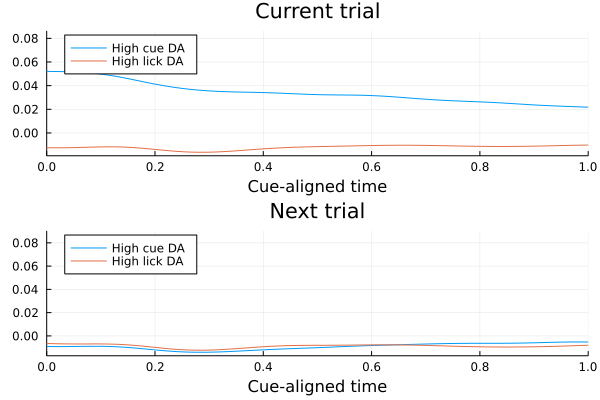

In [44]:
p1 = plot_fig2C_align_cue(x, meta_all, dopa_cue, high_cue, high_lick, lickbin)
p2 = plot_fig2C_align_cue(x, meta_all, dopa_cue, high_cue_next, high_lick_next, lickbin)

title!(p1, "Current trial")
title!(p2, "Next trial")

plot(p1, p2, layout=@layout([p1; p2]))

#### Align by lick

In [45]:
x = LinRange(-MAX_CUE_TO_LAMP_ON - padding, padding, size(dopa_lick,1))
lickbin = [3.5, 4];

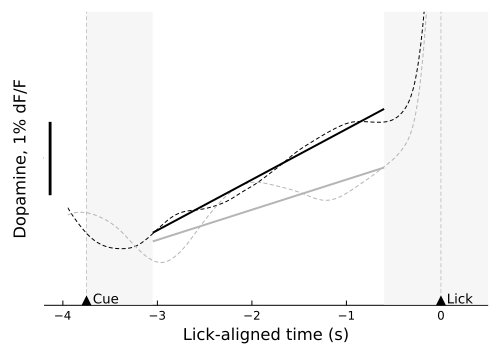

In [46]:
fig2C = plot_fig2C(x, meta_all, dopa_lick, high_cue_next, high_lick_next, lickbin, padding)

## Figure 2

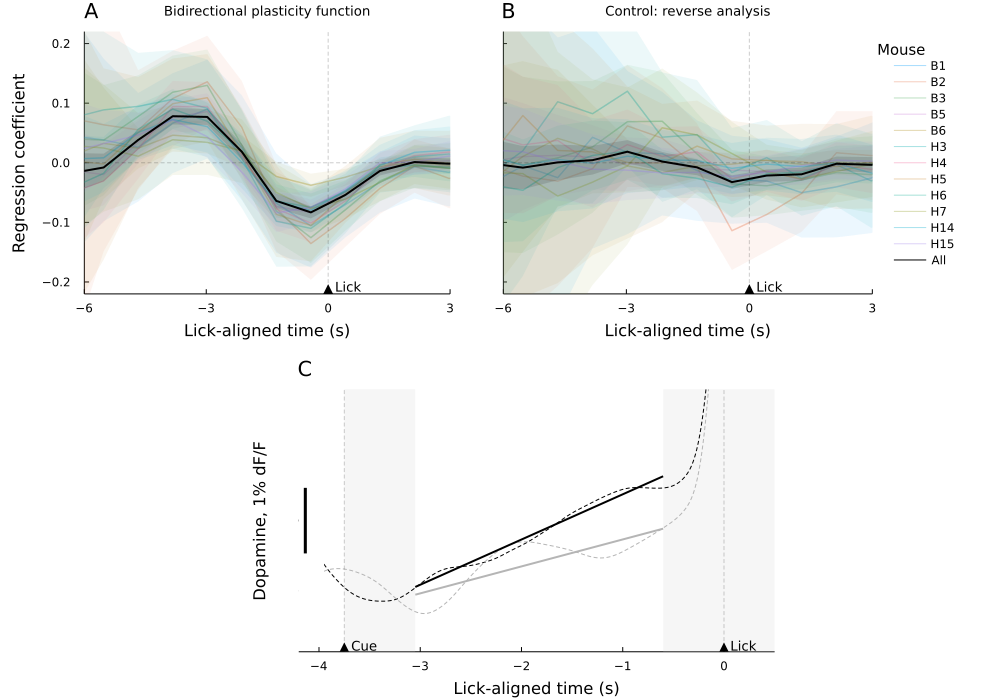

In [47]:
plot_fig2(fig2AB, fig2C)

## Categorical model

In [56]:
using HypothesisTests, CategoricalArrays

In [67]:
_, _, df, df_meta = get_bidirectional_fn(meta_all, bins_all, sessions;
    baseline_normalization=true,
    lickbin=(0, 17),
    reverse=false)

df.is_rewarded = categorical(df_meta.is_rewarded);

In [68]:
lm(@formula(a ~ 0 + is_rewarded), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

a ~ 0 + is_rewarded

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                         Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
is_rewarded: false   0.0004229  0.000151907   2.78    0.0054   0.00012516   0.00072064
is_rewarded: true   -0.0019168  0.000362473  -5.29    <1e-06  -0.00262726  -0.00120635
──────────────────────────────────────────────────────────────────────────────────────